# Notebook for multiple sessions

In [38]:
import numpy as np
import pandas as pd

from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.model_selection import cross_val_score

In [2]:
from importlib import reload

from wombats import utils
from wombats import metrics
from wombats import models
import random
# if changes to the files run this to reload the moduls
utils = reload(utils)
metrics = reload(metrics)
models = reload(models)

In [3]:
data_file = Path('../data/steinmetz/steinmetz_all.npy')
data_folder = Path('../data/steinmetz/')
if not data_file.exists():
    data = utils.load_steinmentz()
    data_folder.mkdir(parents=True)
    data_file.touch()
    np.save(data_file, data)
else:
    data = np.load(data_file, allow_pickle=True)

In [4]:
n_sessions = len(data)

In [5]:
#@title Representative session
#@markdown Let's see which session has more neurons in the areas that we are going to use and how many neurons it has.

brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                  ["MOp", "MOs"],
                  ]
regions = ["visual", "motor"]

def count_neurons_per_brain_area():
    neurons_in_session = []
    for i in range (0,n_sessions):
        session = data[i]
        brain_areas = session['brain_area']

        neurons_in_area = []
        for group in brain_groups:
            count = 0
            for area in group:
                count += np.count_nonzero(brain_areas == area)
            neurons_in_area.append(count)
        neurons_in_session.append(neurons_in_area)
    return neurons_in_session

def plot_areas_sessions(sessions, neurons_in_session):
    fig, ax = plt.subplots(figsize=(18, 5))
    neurons_in_session = np.asarray(neurons_in_session).T
    im = ax.imshow(neurons_in_session)
    ax.set_xticks(np.arange(len(sessions)))
    ax.set_yticks(np.arange(len(regions)))
    ax.set_yticklabels(regions)
    ax.set_xticklabels(sessions)
    
    for i in range(len(regions)):
        for j in range(len(sessions)):
            text = ax.text(j, i, str(neurons_in_session[i,j]),
                           ha="center", va="center", color="w")
    ax.set_title("Number of neurons per brain area")
    fig.tight_layout()
    plt.show()
    
    
def get_representative_sessions(min_visual=1, min_motor=1):
    representative_sessions = []
    new_neurons = []
    neurons_in_session = count_neurons_per_brain_area()
    
    for session, n_neurons in enumerate(neurons_in_session):
        if(n_neurons[0] > min_visual and n_neurons[1] > min_motor):
            representative_sessions.append(session)
            new_neurons.append(n_neurons)
    plot_areas_sessions(representative_sessions, new_neurons)
    
    return representative_sessions


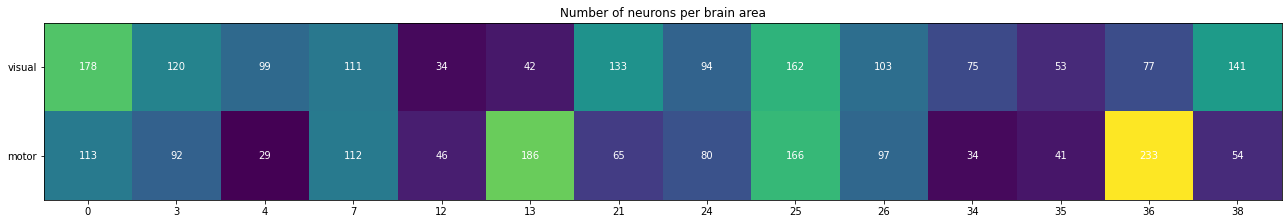

In [6]:
idx_session  = get_representative_sessions(20, 20)
# Get subset of selected sessions:
data = data[idx_session]

In [7]:
# DEFAULTS
N_XVAL = 10 # cross validation
DOWNSAMPLING_FACTOR  = 'all'  # 'all'-> implies that the analisis time window is compressed to 1
TRIAL_RANGE = np.array([-0.5, 2])
SAMP_RATE = 0.01

N_SESSIONS = len(data)


In [8]:
print(N_SESSIONS)

14


## Functions to get coefficients

In [14]:
## TODO: alternatives for these functions.
# take out obtaining performance and the prediction?

def get_a1(stim, region_dat):
    
    n_region_neurons = region_dat.shape[0]
    n_analysis_time_bins = region_dat.shape[2]
    
    if n_analysis_time_bins==1:
        region_dat = region_dat.squeeze().T  # reshapes from neurons x trial x 1 bin, to trials x neurons
        
        # Model Linear Regression
        encoder, encoder_coefs, encoder_model = models.train_linear_encoder(stim, region_dat)
        A1 = encoder_coefs
        
        # get training data prediction
        region_dat_hat = encoder(stim)  
    
        # get performance
        encoder_perf = get_xval_perf(model=encoder_model, input_data=stim, output_data=region_dat, scoring='explained_variance')
    else:
        # need to implement a method for time window iteration
        raise NotImplementedError
    
    return A1, encoder_perf, region_dat_hat


def get_a2(region1_dat, region2_dat):
    """
    :param region1_dat: generated output from a1
    """
    
    # Get data
    #region2_dat = utils.get_region_data(train_set, region=region2, data_type='fr') 
    n_region2_neurons = region2_dat.shape[0]
    n_analysis_time_bins = region2_dat.shape[2]
    
    if n_analysis_time_bins==1:
        region2_dat = region2_dat.squeeze().T  # reshapes from neurons x trial x 1 bin, to trials x neurons
        
        # Model Linear Regression
        transition, transition_coefs, transition_model = models.train_linear_transition(region1_dat, region2_dat)
        A2 = transition_coefs
        
        # get training data prediction
        region2_dat_hat = transition(region1_dat)

        # get performance
        transition_perf = get_xval_perf(model=transition_model, input_data=region1_dat, output_data=region2_dat, scoring='explained_variance')  

    else:
        # need to implement a method for time window iteration
        raise NotImplementedError
    
    return A2, transition_perf, region2_dat_hat


def get_a3(region_dat, output_dat):
    n_region_neurons = region_dat.shape[0]
    n_analysis_time_bins = region_dat.shape[2]
    
    if n_analysis_time_bins==1:
        region_dat = region_dat.squeeze().T  # reshapes from neurons x trial x 1 bin, to trials x neurons
        
        # Model Linear Regression
        decoder, decoder_coefs, decoder_model = models.train_logistic_decoder(region_dat, output_dat)
        A3 = decoder_coefs
        
        # get prediction
        region_dat_hat = decoder(region_dat)
    
        # get performance
        decoder_perf = get_xval_perf(model=decoder_model, input_data=region_dat, output_data=output_dat, scoring='balanced_accuracy')
    else:
        # need to implement a method for time window iteration
        raise NotImplementedError
    
    return A3, decoder_perf, region_dat_hat

def get_ae(A1, A2, A3):
    return A1@A2@A3

def get_model_output(stim, AE=None, A1=None, A2=None, A3=None, output_type='bool'):
    
    if AE is None:
        linear_output = stim @ A1 @ A2 @ A3
    else:
        linear_output = stim @ AE
        
    if output_type=='prob':
        output = utils.sigmoid(linear_output).flatten()
    elif output_type == 'bool':
        output = (linear_output>0).flatten()
        
    return output

In [10]:
def get_xval_perf(model, input_data, output_data, n_xval=N_XVAL, scoring='explained_variance'):
    
    if output_data.ndim==1:
        output_data = output_data[:, np.newaxis]

    n_outputs = output_data.shape[1]
    
    perf = np.zeros((n_outputs, n_xval))
    for output_idx in range(n_outputs):
        perf[output_idx] = cross_val_score(model, input_data, output_data[:, output_idx], cv=n_xval, scoring=scoring)
        
    return perf

def regression_performance_by_neuron(data, data_hat, xval_perf):
    #MSE and R2 per unit
    scores = pd.DataFrame(columns = ['r2', 'xval_r2', 'mse', 'nrmse'])
    scores['r2'] = metrics.r2(data.T, data_hat.T)
    scores['mse'] = metrics.mse(data.T, data_hat.T)
    scores['nrmse'] = metrics.nrmse(data.T, data_hat.T)
    scores['xval_r2'] = np.median(xval_perf,axis=1)

    return scores.mean()


# TODO: full model metrics
# (1) against animal choice 
# (2) against correct choice



In [15]:
%%time 

region1 = 'visual'
region2 = 'motor'
data_type = 'fr'
analysis_time_window =  np.array([0,0.5]) # time window to analizee


exclude_pre = abs(analysis_time_window[0]-TRIAL_RANGE[0])
exclude_post  = abs(analysis_time_window[1]-TRIAL_RANGE[1])

A1 = {i:[] for i in range(N_SESSIONS)}
encoder_perf = {i:[] for i in range(N_SESSIONS)}

A2 = {i:[] for i in range(N_SESSIONS)}
transition_perf = {i:[] for i in range(N_SESSIONS)}

A3 = {i:[] for i in range(N_SESSIONS)}
decoder_perf = {i:[] for i in range(N_SESSIONS)}

## the below score tables assume binary outputs from the model. 
# 1) a more flexible (perhaps accurate) output would consider the probability of a response being left or right.
# 2) a second alternative, is to consider probability values of less than some threshold to be no responses,
# - for example, if |prob-0.5|<thr -> consider that a no response from model 
# 3) make model 

model_binary_scores = {session_i: pd.DataFrame(columns = ["correct_v_subject", "correct_v_model", "subject_v_model"], 
                                        index = ["train", "val", "nogo", "noresp", "nono"]) for session_i in range(N_SESSIONS)}

for session_i in range(N_SESSIONS):
    session_data = data[session_i]

    session_data['fr'] = utils.spikes_to_fr(session_data['spks'], 
                                    samp_rate=SAMP_RATE, 
                                    downsampling_factor=DOWNSAMPLING_FACTOR, 
                                    exclude_pre=exclude_pre, 
                                    exclude_post=exclude_post,
                                   )

    train_set, val_set, nogo_set, noresp_set, nono_set = utils.split_validation_set(session_data)    

    data_splits = {"train": train_set, "val": val_set, 'nogo': nogo_set, 'noresp': noresp_set, "nono": nono_set}

    # get train data
    stim = train_set['stims']
    region1_data = utils.get_region_data(train_set, region=region1, data_type=data_type) 
    region2_data = utils.get_region_data(train_set, region=region2, data_type=data_type) 
    subject_resp = train_set['response']>0

    # train the model
    A1[session_i], encoder_perf[session_i], encoder_output  = get_a1(stim, region1_data)
    A2[session_i], transition_perf[session_i], transition_output  = get_a2(encoder_output, region2_data)  ## input is encoder output
    A3[session_i], decoder_perf[session_i], decoder_output  = get_a3(region2_data, subject_resp)

    # A's pertbation or not

    AE = get_ae(A1[session_i], A2[session_i], A3[session_i])

    for data_div in ["train", "val", "nogo", "noresp", "nono"]:
        stim = data_splits[data_div]["stims"]

        subject_resp = data_splits[data_div]["response"] > 0
        correct_resp = data_splits[data_div]["delta_contrast"] > 0

        model_resp = get_model_output(stim, AE=AE)

        if data_div == "nogo":  # subject responds
            model_binary_scores[session_i].loc[data_div, "correct_v_subject"] = 0
            model_binary_scores[session_i].loc[data_div, "correct_v_model"] = 0  ## or  np.mean ( np.abs(model_resp-0.5) < thr) 
            model_binary_scores[session_i].loc[data_div, "subject_v_model"] = metrics.binarry_acc(subject_resp, model_resp)     
        elif data_div == "noresp":  # there is a contrast 
            model_binary_scores[session_i].loc[data_div, "correct_v_subject"] = 0 
            model_binary_scores[session_i].loc[data_div, "correct_v_model"] = metrics.binarry_acc(correct_resp, model_resp)
            model_binary_scores[session_i].loc[data_div, "subject_v_model"] = 0  ## or  np.mean ( np.abs(model_resp-0.5) < thr)
        elif data_div == "nono":
            model_binary_scores[session_i].loc[data_div, "correct_v_subject"] = 1     
            model_binary_scores[session_i].loc[data_div, "correct_v_model"] = 0  ## or  np.mean ( np.abs(model_resp-0.5) < thr)       
            model_binary_scores[session_i].loc[data_div, "subject_v_model"] = 0  ## or  np.mean ( np.abs(model_resp-0.5) < thr) 
        else:
            model_binary_scores[session_i].loc[data_div, "correct_v_subject"] = metrics.binarry_acc(correct_resp, subject_resp)     
            model_binary_scores[session_i].loc[data_div, "correct_v_model"] = metrics.binarry_acc(correct_resp, model_resp)        
            model_binary_scores[session_i].loc[data_div, "subject_v_model"] = metrics.binarry_acc(subject_resp, model_resp)

    print(".", end="")
        

..............CPU times: user 5min 20s, sys: 5.57 s, total: 5min 26s
Wall time: 34.8 s


In [58]:
model_binary_scores[1]

,correct_v_subject,correct_v_model,subject_v_model
train,0.926316,1,0.926316
val,1,1,1
nogo,0,0,0.411765
noresp,0,1,0
nono,1,0,0


In [73]:
all_scores = pd.DataFrame()
for session_i in range(N_SESSIONS):
    model_binary_scores[session_i]["trial_set"] = list(model_binary_scores[session_i].index)
    a = pd.melt(model_binary_scores[session_i], id_vars='trial_set', value_vars=["correct_v_subject", "correct_v_model", "subject_v_model"], value_name="score", var_name="comp")
    a["session_num"] = session_i
    #a["trial_set"] = list(model_binary_scores[session_i].index)
    
    all_scores = pd.concat( (all_scores, a) )
    
all_scores = all_scores.reset_index(drop=True)

In [74]:
all_scores

,trial_set,comp,score,session_num
0,train,correct_v_subject,0.877358,0
1,val,correct_v_subject,0.833333,0
2,nogo,correct_v_subject,0,0
3,noresp,correct_v_subject,0,0
4,nono,correct_v_subject,1,0
...,...,...,...,...
205,train,subject_v_model,0.929487,13
206,val,subject_v_model,0.833333,13
207,nogo,subject_v_model,0.677966,13
208,noresp,subject_v_model,0,13


In [92]:
all_scores.to_csv("../data/single_val_results.csv")

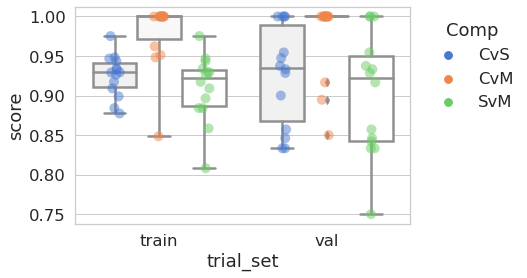

In [91]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
f,ax =plt.subplots()

sns.boxplot(data=all_scores[all_scores.trial_set.isin(["train","val"])], y = "score", x="trial_set", hue='comp', color='white', whis=100, ax=ax)
sns.stripplot(data=all_scores[all_scores.trial_set.isin(["train","val"])], y = "score", x="trial_set", hue='comp', alpha=0.5, dodge=True, size=10, ax=ax)
handles, labels = ax.get_legend_handles_labels()  
ax.legend(handles[3:], ['CvS','CvM','SvM'], title='Comp', bbox_to_anchor=(1.02, 1), frameon=False)

In [67]:
utils=reload(utils)
train_set, val_set, nogo_set, noresp_set, nono_set = utils.split_validation_set(session_data)    
data_splits = {"train": train_set, "val": val_set, 'nogo': nogo_set, 'noresp': noresp_set, "nono": nono_set}


In [70]:
len(session_data['response']), len(train_set['response']), 

(343, 156)

In [96]:
cnt=0
for k,v in data_splits.items():
    cnt+=len(v['response'])
print(cnt)

214


In [63]:
data_div = "noresp"

stim = data_splits[data_div]["stims"]
subject_resp = data_splits[data_div]["response"] > 0
correct_resp = data_splits[data_div]["delta_contrast"] > 0
model_resp = get_model_output(stim, AE=AE, output_type='prob')

In [55]:
data_splits[data_div]["response"]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

In [84]:
data_splits[data_div]["delta_contrast"]

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  , -0.5 ,  0.  , -0.75,  0.5 ,
        0.  ,  0.5 , -0.75, -0.75, -1.  ,  0.  , -1.  ,  0.  ,  0.  ,
       -0.75, -0.75, -0.75,  0.  ,  0.  , -0.25,  0.  ,  0.  , -0.25,
        0.  ,  0.  ,  0.  , -0.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.25,
       -0.5 , -1.  , -0.75, -0.75, -0.75, -0.75, -0.75, -0.75,  0.5 ,
        1.  ,  0.  ,  0.5 ,  0.  ,  0.  ,  0.  ,  0.25,  0.  , -0.5 ,
        0.5 ,  0.75, -0.25,  0.  , -0.5 , -0.25, -0.5 , -0.5 , -0.75,
       -0.75, -0.75])

In [80]:
np.around(model_resp, 2)

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.  , 0.01, 0.  , 1.  , 0.01, 1.  , 0.  , 0.  ,
       0.  , 0.01, 0.  , 0.01, 0.99, 0.  , 0.  , 0.  , 0.01, 0.01, 0.  ,
       0.01, 0.01, 0.08, 0.01, 0.01, 0.01, 0.08, 0.01, 0.01, 0.01, 0.01,
       1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 1.  ,
       0.01, 1.  , 0.01, 0.01, 0.01, 1.  , 1.  , 0.51, 1.  , 1.  , 0.08,
       0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [81]:
model_resp[data_splits[data_div]["delta_contrast"]==0]

array([0.00814823, 0.00814823, 0.00814823, 0.00814823, 0.00814823,
       0.00814823, 0.00814823, 0.00814823, 0.00814823, 0.00814823,
       0.00814823, 0.00814823, 0.00814823, 0.00814823, 0.00814823,
       0.00814823, 0.00814823, 0.00814823, 0.98618193, 0.00814823,
       0.00814823, 0.00814823, 0.00814823, 0.00814823, 0.00814823,
       0.00814823, 0.00814823, 0.00814823, 0.00814823, 0.00814823,
       0.00814823, 0.00814823, 0.00814823, 0.00814823, 0.99999839,
       0.00814823])

In [61]:
metrics.binarry_acc(data_splits[data_div]["delta_contrast"], data_splits[data_div]["response"])

0.4864864864864865

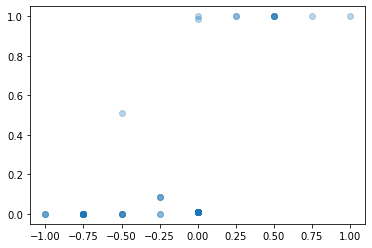

In [74]:
plt.scatter(data_splits[data_div]["delta_contrast"], model_resp, alpha=0.3)

In [75]:
import scipy.stats as ss



In [76]:
ss.pearsonr(data_splits[data_div]["delta_contrast"], model_resp)

(0.5920109487079006, 2.770492420510131e-08)

In [77]:
ss.spearmanr(data_splits[data_div]["delta_contrast"], model_resp)

SpearmanrResult(correlation=0.8612174177568852, pvalue=7.436808158099207e-23)

In [65]:
stims = utils.get_stimulus(session_data)
delta_contrast = session_data['contrast_left']-session_data['contrast_right']
response = utils.get_response(session_data)
spks = session_data['spks']

n_trials = len(session_data['response'])
all_trials = np.arange(n_trials)

no_resp_trials = np.where(session_data['response']==0)[0]
no_go_trials = np.where(delta_contrast==0)[0]

valid_trials = np.setdiff1d(all_trials, no_resp_trials)
valid_trials = np.setdiff1d(valid_trials, no_go_trials)
n_valid_trials = len(valid_trials)

In [68]:
no_resp_trials.shape, no_go_trials.shape, 

((74,), (58,))

In [69]:
mn_trials

214

In [24]:
np.sort(np.random.permutation(np.arange(10))[:3])

array([0, 1, 5])

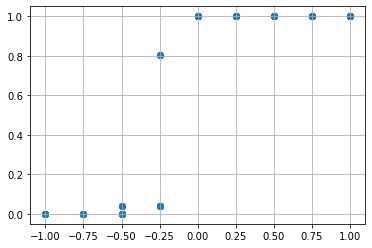

In [46]:
plt.scatter(stim[:,1]-stim[:,2],full_model_output)
plt.grid()

In [57]:
full_model_output[np.sign(stim[:,1]-stim[:,2])==0].mean()

0.9999901395960847

In [58]:
output[np.sign(stim[:,1]-stim[:,2])==0].mean()

0.3

In [60]:
output.mean()

0.5079365079365079

We noted a model bias in session 0 for the model to output left(1) when the difference in contrast is zero. However, the subject responds left at a 30% when input is zero.

In [53]:
data[2].keys()

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])

In [75]:
new_encoder_output, pert_neu = A1_pert(encoder_output, 10)

In [76]:
print(pert_neu)

[60, 62, 165, 73, 18, 162, 21, 36, 105, 108]


In [77]:
new_encoder_output[:,60]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [31]:
stim # columna 1 no importa. Columna 2 y 3 contraste,

array([[1.  , 1.  , 0.  ],
       [1.  , 0.  , 0.5 ],
       [1.  , 1.  , 0.5 ],
       [1.  , 0.5 , 1.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 1.  , 0.5 ],
       [1.  , 0.5 , 0.  ],
       [1.  , 0.5 , 0.25],
       [1.  , 1.  , 0.  ],
       [1.  , 0.5 , 0.  ],
       [1.  , 0.  , 1.  ],
       [1.  , 1.  , 1.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.5 , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.5 , 0.25],
       [1.  , 0.25, 1.  ],
       [1.  , 1.  , 0.5 ],
       [1.  , 0.5 , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.25],
       [1.  , 0.5 , 1.  ],
       [1.  , 0.25, 0.  ],
       [1.  , 1.  , 0.25],
       [1.  , 0.  , 0.5 ],
       [1.  , 0.  , 1.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.5 ],
       [1.  , 0.  , 1.  ],
       [1.  , 0.5 , 0.  ],
       [1.  , 0.25, 0.25],
       [1.  , 0.5 , 0.  ],
       [1.  , 0.  , 1.  ],
 

In [21]:
from sklearn.linear_model import LinearRegression
transition_model =  LinearRegression(fit_intercept=False)

get_xval_perf(model=transition_model, input_data=encoder_output, output_data=region2_data.squeeze().T, scoring='explained_variance')

array([[-0.02364648, -0.34645026, -0.19626273, ...,  0.08014788,
        -0.01459022, -0.02657762],
       [ 0.02129328,  0.05625523,  0.02480889, ..., -0.00446165,
         0.        , -0.05538559],
       [-0.1595742 ,  0.38423209,  0.31343135, ..., -0.74435528,
        -0.2324751 ,  0.09542615],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.03840297,  0.        ,  0.05387747, ..., -0.09689126,
        -0.01677844,  0.01414237],
       [ 0.00636282,  0.06527715,  0.00889748, ..., -0.28528214,
         0.        ,  0.07493322]])

In [22]:
models = reload(models)
decoder, decoder_coefs, decoder_model = models.train_logistic_decoder(region2_data.squeeze().T, output)

input_data = region2_data.squeeze().T
output_data = output

n_xval=10
scoring = 'balanced_accuracy'
model = decoder_model

if output_data.ndim==1:
    output_data = output_data[:, np.newaxis]
       
n_outputs = output_data.shape[1]

perf = np.zeros((n_outputs, n_xval))
for output_idx in range(n_outputs):
    perf[output_idx] = cross_val_score(model, input_data, output_data[:, output_idx], cv=n_xval, scoring=scoring)


In [101]:
perf

array([[0.92857143, 1.        , 0.91666667, 0.92857143, 0.91666667,
        1.        , 0.91666667, 0.91666667, 1.        , 0.91666667]])

In [52]:
output_data.shape

(126, 113)

In [14]:
data_set = [None] * N_SESSIONS

session=0
data_set[session] = utils.filter_no_go_choice(data[session])
data_set[session]['fr'] = utils.spikes_to_fr(data_set[session]['spks'], 
                                samp_rate=SAMP_RATE, 
                                downsampling_factor=DOWNSAMPLING_FACTOR, 
                                exclude_pre=EXCLUDE_PRE, 
                                exclude_post=EXCLUDE_POST,
                               )

train_set, val_set = utils.split_validation_set(data_set[session])    

In [17]:
train_set['response']

array([ 1., -1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1.,
       -1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1., -1., -1.,
        1.,  1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1., -1.,  1.,
        1., -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1., -1., -1.,
        1., -1.,  1., -1., -1.,  1., -1., -1., -1.,  1., -1., -1.,  1.,
        1., -1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1., -1., -1.,
       -1., -1.,  1.,  1.,  1., -1.,  1., -1., -1., -1.,  1., -1., -1.,
       -1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,
        1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [ ]:
## perturbaciones en A1: encoder to 0. to afectar la performance de A2